In [2]:
# https://pypi.org/project/lda/
# https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
# http://kldavenport.com/topic-modeling-amazon-reviews/

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

# Cleaning and pre-processing
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import entropy
from sklearn.externals import joblib

In [2]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


# Data Loading and Cleansing

In [5]:
reviews_df = pd.read_json("../../dataset/restaurant_reviews_final_train.json", lines=True)
reviews_df.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,0,2008-11-11,0,4,So when you go to a restaurant like this pleas...,0,---1lKK3aKOuomHnwAkAow
1,1JgaRBX0oiRsvEhHF3ZMjw,1,2011-02-16,7,1,Food was 30 mins late and the pizza guy thinks...,5,---1lKK3aKOuomHnwAkAow
2,2BbFeotL85cIaBjSq1SWiA,1,2010-10-17,1,1,When you say your a vegetarian don't recomend ...,2,---1lKK3aKOuomHnwAkAow
3,5aeR9KcboZmhDZlFscnYRA,0,2013-01-16,0,5,So Fresh Mama let us host a Homeschool Board G...,1,---1lKK3aKOuomHnwAkAow
4,5cbsjFtrntUAeUx51FaFTg,0,2010-11-05,0,1,So I was coming here once a month or so maybe ...,1,---1lKK3aKOuomHnwAkAow


In [71]:
print(reviews_df.shape)

(1500464, 8)


In [5]:
# RUN THIS IF YOU DON'T HAVE IT SAVED ALREADY
# Cleaning and pre-processing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
    
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


doc_clean = [clean(doc) for doc in reviews_df.text]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cw2yuen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cw2yuen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
doc_clean[0:10]

['go restaurant like please expect bit drawn dinner think two half hour large party many said best food life really wonderful say appetizer far imagination main course bit deflating went long day convection u tired slightly delirious service tad slow made dinner feel much like cook thief wife lover thing set plate glass never went empty wine list die for 15000 dessert wine dated titanic one star really main course living expectation set previously',
 'food 30 min late pizza guy think going tip 18 dollar 20 dollar order perhaps two spring short slinky cant add one bite mozzarella stick revel cheese melted seriously could peeled like straight gas station string cheese deep fry something actually avoid cooking it called complain leave hold start laughing calling them stellar managerial skill get kellogg mba back frosted flake think husband order pinch food kid however declare moratorium lower crust put pizza cement shoe else delivers summerlin',
 'say vegetarian recomend potato soup bacon

# Topic Modeling using LDA

In [7]:
def print_top_words(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        topic_names.append(" ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return topic_names

In [8]:
n_features = 100000
n_topics = 100
n_top_words = 3

print("Fitting Count Vectorizer")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english',
                                decode_error='ignore')
tf = tf_vectorizer.fit_transform(doc_clean)

Fitting Count Vectorizer


In [ ]:
#print("Fitting LDA")
#lda = LatentDirichletAllocation(n_components=n_topics, 
#                                max_iter=1,
#                                learning_method='online',
#                                learning_offset=50.,
#                                random_state=0,
#                                n_jobs=1,
#                                verbose=1)
#
#lda.fit(tf)

In [ ]:
# Save model
#joblib.dump(lda, 'lda.pkl')

In [9]:
# Restore model
lda = joblib.load('lda.pkl') 

In [10]:
tf_feature_names = tf_vectorizer.get_feature_names()
topic_names = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: squiggly renovation yalanji
Topic #1: nichtraucherbereich theye riesenauswahl
Topic #2: likea gurken klebrig
Topic #3: sweetish ruhige beefand
Topic #4: onsight khaled bennedict
Topic #5: ramazotti hoggie teevee
Topic #6: wiki lunchlate doorstyle
Topic #7: casears systemgastronomie chineserun
Topic #8: partagent badlands connoiseur
Topic #9: customizations mangolassi ohsoflavorful
Topic #10: stalla coveting mash
Topic #11: timetable mealdrinks hongos
Topic #12: ditzingen vib odessa
Topic #13: grease reviewso fooddefinitely
Topic #14: lvblvd croquetes parolee
Topic #15: midmarket hei pennywort
Topic #16: moment ln lens
Topic #17: locale beurteilen peopleperson
Topic #18: thompson telepathically umis
Topic #19: chickeneggplant waaaaaaaaaaay italianstyle
Topic #20: compatible numbs wonderfully
Topic #21: guirei eachs squarecut
Topic #22: ntc medal millefoglie
Topic #23: meatheavy tripas gao
Topic #24: firegrilled outoftown wahrscheinlich
Topic #25: bartenderwaiter coversation so

# Building the Review-Topic Distribution Matrix

In [11]:
# Compute review-topic distribution vectors
# Each row represents a review's topic distribution
# Each column is the probability of the topic. The sum of all entries in a row should = 1.0 (becuase it's a distirbution)
# review_topic = lda.transform(tf)
# review_topic_df = pd.DataFrame(review_topic)
# review_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000769,0.000769,0.000769,0.000769,0.000769,0.077692,0.000769,0.000769,0.000769,0.000769,...,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769
1,0.001429,0.001429,0.001429,0.287143,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,...,0.001429,0.001429,0.001429,0.001429,0.144286,0.001429,0.001429,0.001429,0.001429,0.001429
2,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
3,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.505000,0.005000,0.005000,0.005000,0.005000,0.005000
4,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,...,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714


In [13]:
# Save Review-Topic Distribution
# review_topic_df.to_csv("review_topic_df.csv", header=False)

In [11]:
# Load Review-Topic Distribution
review_topic_df = pd.read_csv("review_topic_df.csv", header=None, index_col=0)

/home/cw2yuen/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
review_topic_df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
0,0.000769,0.000769,0.000769,0.000769,0.000769,0.077692,0.000769,0.000769,0.000769,0.000769,...,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769
1,0.001429,0.001429,0.001429,0.287143,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,...,0.001429,0.001429,0.001429,0.001429,0.144286,0.001429,0.001429,0.001429,0.001429,0.001429
2,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
3,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.505000,0.005000,0.005000,0.005000,0.005000,0.005000
4,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,...,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714


# Visualizing Review's Topic Distribution

In [63]:
def display_review_topic_dist(review_id, review_topic_df):
    review_text = reviews_df.text[review_id]
    print("Review text: ", review_text)
    review_dist = pd.DataFrame(review_topic_df.loc[review_id])
    review_dist.columns = ['dist']
    print(review_dist.dist.shape)
    
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.title("Topic distribution")
    plt.bar(topic_names, review_dist.dist)
    plt.plot()

Review text:  Stayed at the California Hotel 4th of July weekend. Had read about 777 and decided to try it since the west tower where I was staying at the California is about a 3 minute walk away. I enjoyed the bar so much that I ate every meal during my stay there. Yeah, sounds lame but I don't give a shit, the place was nice and it was too damn hot to be strolling around. The microbrews were about a 3/5. The two I was looking forward to were out but oh well. They had a pale ale called Marker that I settled in on. While in vegas I only eat during happy hour(s) which is 3p-6p and  after midnight. The beers are $2 during HH. The food was 4.5/5..I had (not all at once) wings, nacho supreme, meatlovers flatbread pizza, broiled chicken sandwhich and a pepper crusted ribeye (medium). Man, that damn ribeye was delicious, came with a baked potato and greens for $15.99. When I stayed on the strip last year with friends, I payed $50 for a Ribeye at some place in Ceasars that couldn't touch this

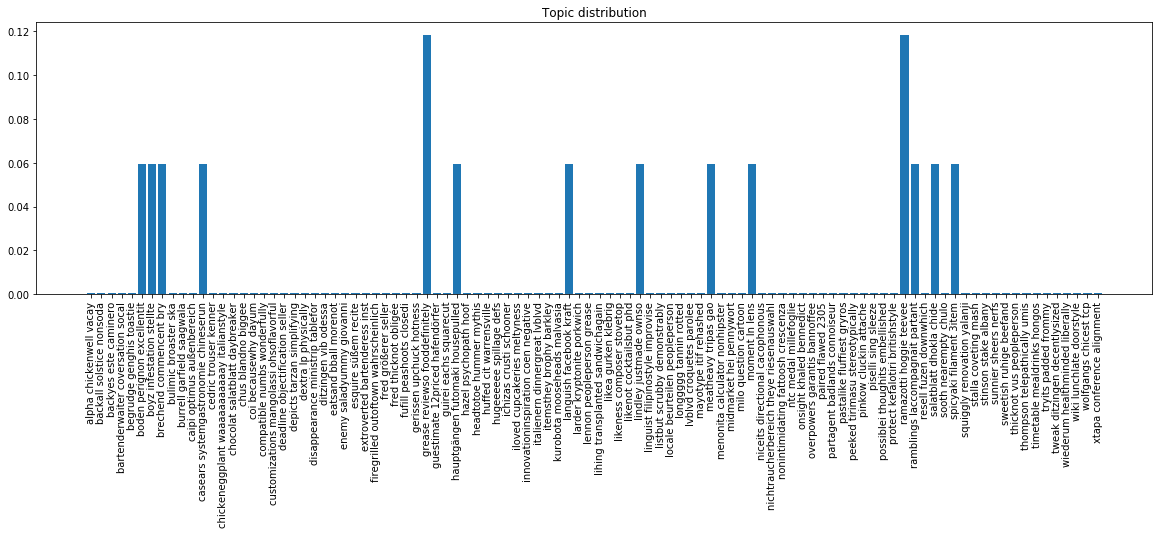

In [64]:
display_review_topic_dist(154, review_topic_df)

Review text:  When you say your a vegetarian don't recomend the potato soup with Bacon. Then don't mess around with me about the refund, with no mea culpa.
(100,)


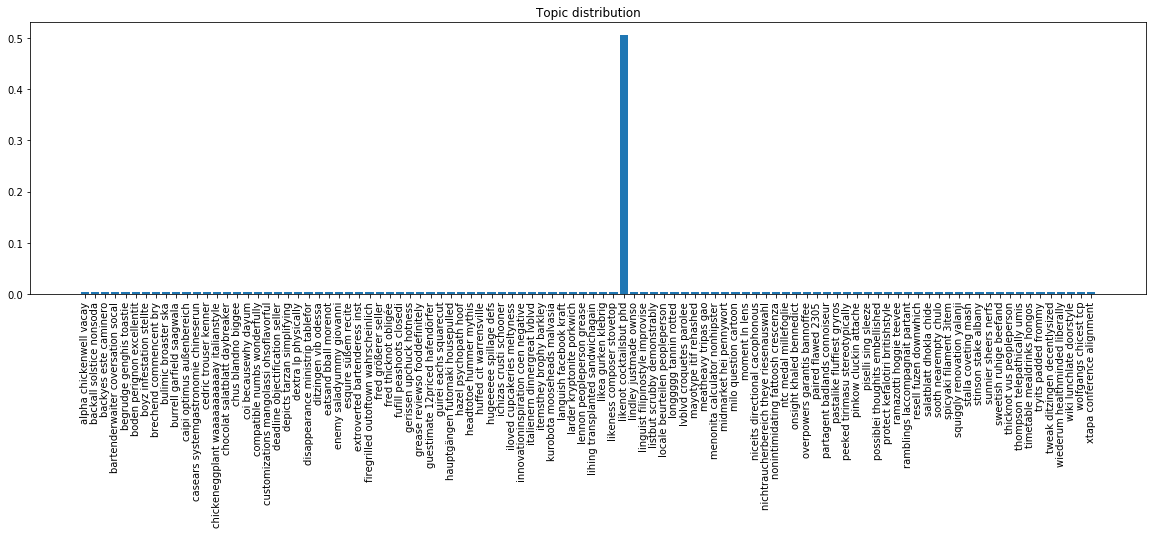

In [62]:
display_review_topic_dist(2, review_topic_df)

Review text:  So Fresh Mama let us host a Homeschool Board Game Day in their space and it was amazing.  The have a really cool area with a fountain and they have a fount of tasty treats of the vegan persuasion.  So counter the naughty with a little nice this year.
(100,)


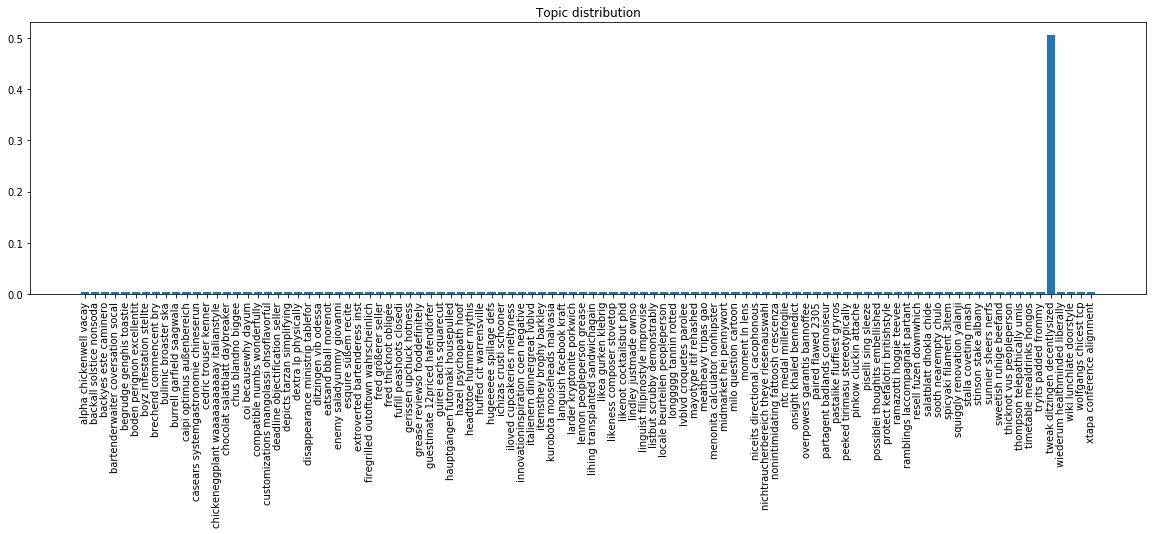

In [63]:
display_review_topic_dist(3, review_topic_df)

# Building the User Sum Rating Table

In [13]:
# Build user sum rating table
user_rating_agg_df = reviews_df.groupby('user_id')['stars'].aggregate(['sum', 'count'])
user_rating_agg_df.sort_values(by='count', ascending=False).head()

,sum,count
user_id,,
CxDOIDnH8gp9KXzpBHJYXw,6923,2209
bLbSNkLggFnqwNNzzq-Ijw,4325,1316
d_TBs6J3twMy9GChqUEXkg,3058,904
cMEtAiW60I5wE_vLfTxoJQ,3616,897
DK57YibC5ShBmqQl97CKog,3305,887


# Building the User-Topic Distribution Matrix

In [44]:
# 1. Iterate each user and get all the user's reviews
# 2. User A’s Topic Space = SUM( rating i / SUM rating * review i topic vector )
# 3. May want to filter out users with too little reviews, these users may not have a very representative topic distribution

user_topics = []

c = 0
for user_id in reviews_df.user_id.unique():
    c += 1
    user_df = reviews_df[reviews_df.user_id == user_id]
    sum_user_rating = user_rating_agg_df[user_rating_agg_df.index == user_id]['sum'][0]
    
    # Initialize user-topic distribution
    user_topic_dist = np.zeros(n_topics)
    
    for review in user_df.iterrows():
        review_id = review[0]
        rating = review[1]['stars']
        topic_dist = review_topic_df.loc[review_id]
        user_topic_dist += (rating+0.0)/sum_user_rating * topic_dist
    
        topic_dist_str = " ".join(format(x, "0.6f") for x in user_topic_dist.values)
        #print(topic_dist_str)
        
    user_topics.append([user_id, topic_dist_str])
    
    #if c % 100 == 0:
    #    print (c)

user_topics_df = pd.DataFrame(user_topics)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [45]:
user_topics_df.columns = ['user_id', 'topic_distribution']
user_topics_df.head()

,user_id,topic_distribution
0,---1lKK3aKOuomHnwAkAow,0.002718 0.002718 0.005553 0.024495 0.002718 0...
1,--2HUmLkcNHZp0xw6AMBPg,0.003738 0.003738 0.003738 0.014800 0.010059 0...
2,--2vR0DIsmQ6WfcSzKWigw,0.007215 0.000601 0.000601 0.007404 0.000601 0...
3,--3WaS23LcIXtxyFULJHTA,0.012888 0.000876 0.008247 0.049153 0.000876 0...
4,--4rAAfZnEIAKJE80aIiYg,0.001812 0.001812 0.006358 0.023024 0.004590 0...


In [46]:
user_topics_df.shape

(111200, 2)

In [47]:
# Save User-Topic Distribution
# user_topics_df.to_csv("user_topic_df.csv", header=False)

In [3]:
# Load User-Topic Distribution
user_topics_df = pd.read_csv("user_topic_df.csv", header=None, names=['user_id', 'topic_distribution'], index_col=0)
user_topics_df.head()

,user_id,topic_distribution
0,---1lKK3aKOuomHnwAkAow,0.002718 0.002718 0.005553 0.024495 0.002718 0...
1,--2HUmLkcNHZp0xw6AMBPg,0.003738 0.003738 0.003738 0.014800 0.010059 0...
2,--2vR0DIsmQ6WfcSzKWigw,0.007215 0.000601 0.000601 0.007404 0.000601 0...
3,--3WaS23LcIXtxyFULJHTA,0.012888 0.000876 0.008247 0.049153 0.000876 0...
4,--4rAAfZnEIAKJE80aIiYg,0.001812 0.001812 0.006358 0.023024 0.004590 0...


# Visualizing Users's Topic Distribution

User ID:  Lfv4hefW1VbvaC2gatTFWA

Reviews:
Stopped by to have a quick lunch with a colleague who recommended. Nice place, not very crowded and good service. 

Had a special of the day: ravioli with grilled chicken. Very good red sauce and ravioli, chicken was kind of eh. It came with a thick piece of toasted Italian bread that was perfect with the meal.
Stopped by with a friend who had been  to IPH and wanted to go back. Very casual atmosphere with a big bar, long list of beers and many TV's.  
Ordered a fall special of Smoke & Fire that is a smoked brisket with a pepper cheese (forgot the name) and an onion ring with hand cut fries.  The brisket comes on a bun that is large and very good.  It definitely had some of the smoke flavor and some spiciness from the cheese.  We definitely enjoyed our food.  The Smoke & Fire "Handheld" sandwich cost $16.  Thought it to be good but the price seems to be a bit high, guess you are paying for the ambiance.

Oh, Yea, the WIFI sucks.  Did not work 

NameError: name 'topic_names' is not defined

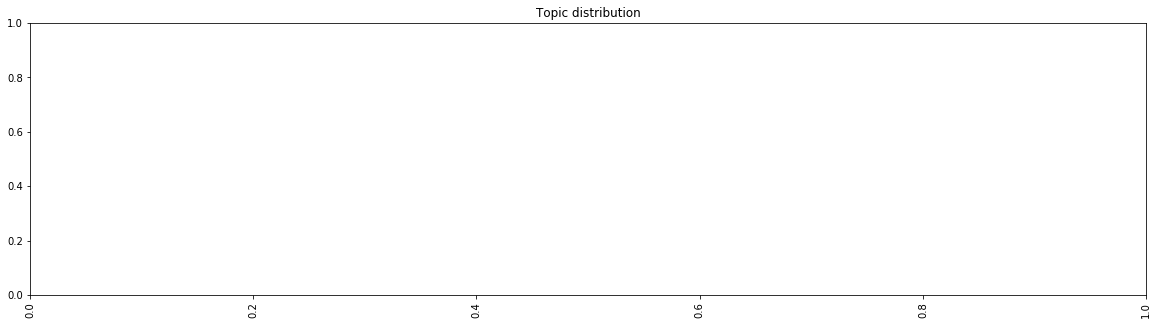

In [6]:
def convert_topic_dist(topic_dist_str):
    return [float(i) for i in topic_dist_str.split(' ')]

def display_user_topic_dist(user_id, user_topics_df):
    print("User ID: ", user_id)
    print("")
    
    print("Reviews:")
    for r in reviews_df[reviews_df.user_id == user_id].iterrows():
        print(r[1].text)
    
    topic_dist = user_topics_df[user_topics_df['user_id'] == user_id]['topic_distribution']
    topic_dist_f = convert_topic_dist(topic_dist.values[0])
    
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.title("Topic distribution")
    plt.bar(topic_names, topic_dist_f)
    plt.plot()
    
display_user_topic_dist('Lfv4hefW1VbvaC2gatTFWA', user_topics_df)

# Build Recommender

In [12]:
# Uses symmetric Kullback–Leibler divergence
def latent_topic_similarity(user_topic_1, user_topic_2):
    return entropy(user_topic_1, user_topic_2)

In [13]:
# For a given user_id, finds the top k nearest neighbors excluding that user
def find_nn(user_id, user_topics_df, k=10):
    user_topic_dist = user_topics_df[user_topics_df.user_id == user_id].topic_distribution.iloc[0]
    user_topic_dist_f = convert_topic_dist(user_topic_dist)
    
    nn_list = []
    for r in user_topics_df.iterrows():
        other_user_id = r[1].user_id
        other_topic_dist = r[1].topic_distribution
        other_topic_dist_f = convert_topic_dist(other_topic_dist)
        similarity_score = latent_topic_similarity(user_topic_dist_f, other_topic_dist_f)
        
        nn_list.append([other_user_id, similarity_score])
        
    nn_df = pd.DataFrame(nn_list)
    nn_df.columns = ['user_id', 'similarity_score']
        
    # Removes the original user
    return nn_df[nn_df.user_id != user_id].sort_values(by='similarity_score', ascending=True)[:k]

find_nn('Lfv4hefW1VbvaC2gatTFWA', user_topics_df, 10)

,user_id,similarity_score
62612,YwaKGmRNnSa3R3N4Hf9jLw,0.099985
111109,zwhty_ZmxbHAHoDfMjNbag,0.100826
73025,dwl0NrgPtTZWT_AKJ0ezjQ,0.101231
26814,ELcQDlf69kb-ihJfxZyL0A,0.104188
69122,bhJ6ivAuSpgXP4JiKWjSZQ,0.106545
8482,3nDUQBjKyVor5wV0reJChg,0.106607
16240,8DGFWco9VeBAxjqsuh1aSw,0.107194
51173,SRK_sUnvRmMwfexoL_DLQA,0.108154
47559,QJI9OSEn6ujRCtrX06vs1w,0.108217
95162,qgbRvkZ8tUiAtNAM34YBzg,0.109636


In [99]:
def find_recommendations(user_id, n_restaurants=20):
    reviewed_business_ids = reviews_df[reviews_df.user_id == user_id].business_id
    nn_user_ids = find_nn(user_id, user_topics_df, 10)
    nn_user_ids = nn_user_ids.set_index('user_id')
    
    # Only recommend positive reviews
    pos_df = reviews_df[reviews_df.stars >= 4] 
    
    # Only recommend from nearest neighbors
    pos_df = pos_df.set_index('user_id')
    recommendations_df = pos_df.join(nn_user_ids, how='inner').sort_values(by='stars', ascending=False)
    
    # Remove recommendations where user has already given a review (e.g. has been to the restaurant)
    pos_df = pos_df.join(reviewed_business_ids, how='left', on='business_id', rsuffix='_r')
    pos_df = pos_df[pd.isnull(pos_df.business_id_r)]
    
    recommendations_df['recommendation_score'] = (6 - recommendations_df.stars) * recommendations_df.similarity_score
    return recommendations_df.sort_values(by='recommendation_score')

# The lower recommendation_score the better
find_recommendations('Lfv4hefW1VbvaC2gatTFWA').head(10)

,business_id,cool,date,funny,stars,text,useful,similarity_score,recommendation_score
user_id,,,,,,,,,
zwhty_ZmxbHAHoDfMjNbag,NxjUiGBNgyDErKXnmQ3s3w,1,2013-09-19,0,5,Yes this place is full of hipsters in an even ...,0,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,4k3RlMAMd46DZ_JyZU0lMg,0,2014-02-05,0,5,We had a great time here last week and enjoyed...,2,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,nYzCr8fcJ2ci4aiB1-hB6w,0,2013-07-24,0,5,I've been here 3 times in the past 4 days. Wh...,3,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,lpYFsXFrojiBZ1kbWR2lZw,1,2011-08-23,0,5,We used to live right by the Tempe location an...,2,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,lF4pEu4_55SSFEo6Q58ftQ,0,2011-07-06,0,5,"Went here on a whim (July 5, 2011) after dropp...",0,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,klddGAcNIpE_aB5sd1hNXw,0,2015-03-25,0,5,My husband surprised me with dinner here after...,0,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,jLxeBgWhLRbII2ACkgH1Sg,7,2013-08-08,4,5,J'adore le pain....et les biscuits....et les g...,9,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,jCR-xC4NqoEajjmstqX8sA,0,2011-10-31,0,5,My husband surprised me by taking me here a co...,1,0.100826,0.100826
zwhty_ZmxbHAHoDfMjNbag,d1pB6SLzLb-4lFq8y5tEnQ,2,2013-11-12,2,5,I can't say anything different from the many o...,2,0.100826,0.100826


## Evaluation

In [7]:
reviews_test_df = pd.read_json("../../dataset/restaurant_reviews_final_test.json", lines=True)
reviews_test_df.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,7dHYudt6OOIjiaxkSvv3lQ,197,2017-11-08,179,5,Auf unserer Rundreise haben wir häufig die Res...,203,--2vR0DIsmQ6WfcSzKWigw
1,9edPSkfXKsJmkZYIaOmA7Q,194,2017-11-06,176,4,Nachdem wir die Las Vegas North Premium Outlet...,199,--2vR0DIsmQ6WfcSzKWigw
2,El4FC8jcawUVgw_0EIcbaQ,122,2015-10-13,109,4,Das MGM Grand ist mit seinen 6.853 Zimmern ein...,130,--2vR0DIsmQ6WfcSzKWigw
3,GHS1rVjO-RMcRB6WJLpCDQ,108,2015-09-16,94,3,In Las Vegas kann man zwischen zwei verschiede...,112,--2vR0DIsmQ6WfcSzKWigw
4,IhlKa2x5J4vr47hjDY8Jnw,11,2013-06-02,7,5,Bei einer meiner letzten Besuche in Stuttgart ...,15,--2vR0DIsmQ6WfcSzKWigw


In [8]:
def find_recommendations_eva(reviews_df, user_id, n_knn=20,similarity_score=0.16):
    reviewed_business_ids = reviews_df[reviews_df.user_id == user_id].business_id
    nn_user_ids = find_nn(user_id, user_topics_df, n_knn)
    nn_user_ids = nn_user_ids.set_index('user_id')

    # Only recommend positive reviews
    pos_df1 = reviews_df[reviews_df.stars >= 4] 
    
    # Keep recommendations where user has already given a review (e.g. has been to the restaurant)
    pos_df2 = pos_df1[pos_df1['business_id'].isin(list(reviewed_business_ids))].set_index('user_id')

    # Only recommend from nearest neighbors
    recommendations_df = pos_df2.join(nn_user_ids, how='inner').sort_values(by='stars', ascending=False)

    # generate recommended restaurants
    # 'label' means groud true, 'recommended?' means prediction
    recommend_list = list(set(recommendations_df[recommendations_df['similarity_score'] < similarity_score].business_id))
    recommend_list_df = pd.DataFrame(data = {'business_id' : recommend_list, 'recommend?': 1}).set_index('business_id')
    result_df = reviews_df[reviews_df.user_id == user_id].join(recommend_list_df, on='business_id')
    result_df['recommend?'].fillna(0, inplace=True)

    result_df.loc[result_df['stars'] >= 4, 'label'] = 1.0
    result_df.loc[result_df['stars'] < 4, 'label'] = 0.0

    return result_df.set_index('user_id')

In [87]:
# The lower similarity_score the better
find_recommendations_eva(reviews_test_df, '--2vR0DIsmQ6WfcSzKWigw')

,business_id,cool,date,funny,stars,text,useful,recommend?,label
user_id,,,,,,,,,
--2vR0DIsmQ6WfcSzKWigw,7dHYudt6OOIjiaxkSvv3lQ,197,2017-11-08,179,5,Auf unserer Rundreise haben wir häufig die Res...,203,0.0,1.0
--2vR0DIsmQ6WfcSzKWigw,9edPSkfXKsJmkZYIaOmA7Q,194,2017-11-06,176,4,Nachdem wir die Las Vegas North Premium Outlet...,199,0.0,1.0
--2vR0DIsmQ6WfcSzKWigw,El4FC8jcawUVgw_0EIcbaQ,122,2015-10-13,109,4,Das MGM Grand ist mit seinen 6.853 Zimmern ein...,130,0.0,1.0
--2vR0DIsmQ6WfcSzKWigw,GHS1rVjO-RMcRB6WJLpCDQ,108,2015-09-16,94,3,In Las Vegas kann man zwischen zwei verschiede...,112,0.0,0.0
--2vR0DIsmQ6WfcSzKWigw,IhlKa2x5J4vr47hjDY8Jnw,11,2013-06-02,7,5,Bei einer meiner letzten Besuche in Stuttgart ...,15,0.0,1.0
--2vR0DIsmQ6WfcSzKWigw,mysCmit5aV2PWNL-Li6ZBw,17,2013-07-11,15,4,"Sehr schönes Steakhouse, in das ich gerne eink...",19,0.0,1.0
--2vR0DIsmQ6WfcSzKWigw,zt5S0bSsc8JAWalRMpSk6Q,10,2013-06-01,8,3,Ich habe bei einer meiner Geschäftsreisen nach...,14,0.0,0.0


In [14]:
# compute accuracy for one user_id
from sklearn.metrics import accuracy_score

user_id = '--2vR0DIsmQ6WfcSzKWigw'
accuracy_score(find_recommendations_eva(reviews_test_df, user_id)['label'], 
               find_recommendations_eva(reviews_test_df, user_id)['recommend?'])

0.2857142857142857

In [15]:
#create a dataframe of all the recommended restaurants for all users
recommend_result = []

for user_id in reviews_test_df.user_id.unique():
    score = accuracy_score(find_recommendations_eva(reviews_test_df, user_id)['label'], 
                   find_recommendations_eva(reviews_test_df, user_id)['recommend?'])
    recommend_result.append([user_id, score])
    f = open("eval_dump.csv","a+")
    f.write("%s,%s\n" % (user_id, score))
    print("%s,%s\n" % (user_id, score))
    f.close()

recommend_result

--2vR0DIsmQ6WfcSzKWigw,0.2857142857142857

--fF_pQlaU9sME-HLCoHlQ,0.6666666666666666

-0-R267zNIQDPI9rxJlprQ,0.5

-05T0q5BxB9g0RCKiGYoyQ,0.5

-0dOdNR_GMZq0yHWYuwRaw,0.0

-0lFv3aQ5XI9VdiDwsL2vA,0.14285714285714285

-0x2ov-qcCopv32Imm-TYg,0.0

-1-pTXLHph2vcqRCNeT4_Q,0.0

-16aKjco1c0RJ7c4U-q_Kw,0.13333333333333333

-1VvsQCtS4hW32hnalTlzw,0.75

-1YGFe7qDm2yl43AqCbMNg,0.23076923076923078

-1immOUG00aBdpcQPFYQhA,0.16666666666666666

-2EcIDIDnA8H7N81jwYpcQ,0.5555555555555556

-2j0CsqJasPaeAxSMOjB7g,0.5

-3Tgw9br9O68emgrgFj48Q,0.8333333333333334

-3ftjzYHSLAGAniH--GkyA,0.625

-3mAqeRyjjb3JJmbYG0vkA,0.16666666666666666

-4pU1kYulMf2L07Rk579fA,0.0

-55DgUo52I3zW9RxkZ-EAQ,0.0

-594af_E7Z9VVjQc9pJK3g,0.2328767123287671

-59ijX9Vx-sY30usVhBFHw,0.25

-5BaVHOAvLrc3u9VNj41-Q,0.0

-5M7Gg90-iZtQny0h2OGmQ,0.16666666666666666

-5Q56Z3K0ZpaDStmOPCt5g,0.15789473684210525

-5UyALLOkv4dZLSjMFHivA,0.8333333333333334

-5ye1ya0wRQhNRF9NfQ1fA,0.23529411764705882

-65LqBTk1lT7aElQUm8naw,0.14285714285714285

-6_w31

-frBmh8tZDGwezlH5tyXiA,0.3333333333333333

-fzk0slIjoFQD1eWjx1uWw,0.42857142857142855

-g-x5DiRxV0rXCyFkfhU3A,0.875

-g9ds-uxJNmaIDA9uQ-bOw,0.46153846153846156

-gs7QKwBufv5UIhTkVqiYg,0.125

-guyVbrMJxVeBcfdRQc6xw,0.33636363636363636

-h9FFKHe1xVMS5m7bjzDdQ,0.2727272727272727

-h9mRHGLJhcI8edLZdQZkw,0.2727272727272727

-hE8tysL4iN_BQ_wSnRBOA,0.5

-hKniZN2OdshWLHYuj21jQ,0.2631578947368421

-hMav1396QxA4e3ZNDlsBw,0.2857142857142857

-hPQU8OfxfztYZYgr5GTsw,0.4444444444444444

-hUgrj7Lzir3yLUYrMYQ4g,0.6136363636363636

-hnBzgVoRoqLrGVSxO0ilg,0.52

-hxUwfo3cMnLTv-CAaP69A,0.5652173913043478

-iH6p8R39sB96EVFSyh1lQ,0.29411764705882354

-j3YZFnfE6-w-d_RovmFkQ,0.5

-jVPgq2zQZS5vVLGEDLDrQ,0.0

-jb2JmZ_NYz7Smb0c_9dNw,0.16666666666666666

-jpMKvL0mzVwzMj-7n8p0g,0.5454545454545454

-jpu5KX95HLWJdztLq53uQ,0.2702702702702703

-kCxMXN0_kOoQuGbSJk53Q,0.5

-kHOvR2jVRIJgUMtGEunTQ,0.0

-kRQLEDxrEBVNXImyAt_ug,0.4

-kYa7kfJCvLtcLGzs7UxLg,0.4444444444444444

-lEaTSpvijdhR7NkVQB5xQ,0.46153846153846156

-lORwg

0ISg5l9THFILWeaCv4gmiw,0.18181818181818182

0IYUEBzQR8CjdWEaFUlOSw,0.2

0IbSetaXJgHMMc4ViRkDxA,0.46153846153846156

0IknfAj4nG_JZ8JiGSCzUg,0.375

0JPs-VvZEC439plCy9J-sg,0.1111111111111111

0JxDCgC1q7VV2z3Bi-5xog,0.2

0K4-ezsJnuwOTbc1jbtCjg,0.3103448275862069

0KEqNzBQlhtq8pwrrM2ejA,0.75

0KV4m_0y676-aS86rJTXBw,0.3333333333333333

0KW2QuGUmKPKLV7ZwwwO3Q,0.2222222222222222

0KhhyffsaaTZkwuyM-16iw,0.2

0KueQxXgax9GlbZ0UNaGlg,0.32857142857142857

0Kz8_kEnQcnztdGrovnWFw,0.18518518518518517

0LBzIPKT8KE7GV9VWVmnlQ,0.625

0LQSY9s-pTcIfRx3C9vB7Q,0.5384615384615384

0LUt7xSvYgLpL0zBezI5QA,0.3125

0Lfj5bBAWXgIEzvzKyFgfg,0.46153846153846156

0MLoSJ5Xv_yO8_eaAZcJZQ,0.3333333333333333

0Mfs3RDXYtuBnJ1RHWqeAA,0.15384615384615385

0Mh_zzwUqiVJDKObtySjLA,0.42857142857142855

0Mi_djbalB-ZyLapijRqZg,0.4166666666666667

0Mknw3MwhcEqX5MXvn6i3g,0.0

0NqTpMMl-3gkk8yiryvdJw,0.3333333333333333

0O2otj7iEkWunfYhfB1TZg,0.5714285714285714

0O9Kr4hOvUezlMjZfA2AmA,0.4166666666666667

0OJBd3mze0FoWTz0aoFIcA,0.16666

0syC71vtTGGzSeGzfTR6vw,0.16

0t2sLc6zJTWEWHBnla0QHA,0.36363636363636365

0tJNWu6aICRiUcHEczHQpw,0.375

0th8ptkwY95l1VRU9l1C4Q,0.14285714285714285

0uEqdNTVj-I7zM83bbcgsg,0.5555555555555556

0uIGx_NZmzLVrToCD9bTjw,0.2727272727272727

0ue099mV8HagMik3pDtlzg,0.0

0v-cQh4dHkX4a1xcU8nnUA,0.8

0v1Nblhu3yeT_jDxw1VfqQ,0.8333333333333334

0v4sabX7a6r8blrGtzVKuw,0.5555555555555556

0vKcL1PFHQxn94h2LU1wPw,0.2857142857142857

0vXEsuzxnHFiHR9lmoC2vw,0.09090909090909091

0vY5rb0Ylajp-bhvo9Xxow,0.0

0w1qrBdJQiReCnCJS7cmEw,0.4583333333333333

0w6SADnIcM7-KtJD4JLepA,0.6666666666666666

0w7Zd4RF6ot3sro-qHvd6A,0.5

0wWo_2D0TVrUqqLpI1wcxw,0.14285714285714285

0wkrIyA7beFsaYNrDsX2qw,0.35294117647058826

0wwGMP2WU9BNNTR7pmn9LA,0.375

0x-sRPMqmtsk1SmmzuTCtg,0.5

0x0_ohYXAhYNtGcGZdWefw,0.17647058823529413

0x42Ja68BHCViWSJW-5d8A,0.5

0xBrS_K7dxTB8kBRgTmPTw,0.2

0xLek5Zgnp4k6nsbI66YZw,0.4444444444444444

0xZ9qKUrlCxtiq75tX-IcQ,0.2857142857142857

0xp4Um4k0lCVNaOo5fhaLA,0.0

0xzgFN6O0tTb_iyu0uu8bQ,0.33333333333

1RWx8as-G_O4glVw_yCCPA,0.07692307692307693

1Rto8qXutcsrKBLEKeasLQ,0.14285714285714285

1SECHBtEY183p8mmdNZ9Dw,0.4

1SFfDyD0TA1dnXmbPTRMVQ,0.24

1SFj4GRZJoRYRUk_o5NhqA,0.32727272727272727

1SK2DPCcCF7zRlbch8Yj-g,0.16666666666666666

1SZSUORTszEQePOsk0oVJQ,0.3333333333333333

1Sas_JhChG9ygG6lLCXDYA,0.16666666666666666

1Sd4p9TIjoTMW7ReFBY-hQ,0.21739130434782608

1Sg3J5jh5YSOqmEKT0PC0w,0.0

1SmmRBCFST2fk930ifdbPw,0.42857142857142855

1T-rePv-lLJDO5gVGFyfFQ,0.2

1T1x_58P-As_rB1mGITklw,0.21621621621621623

1T4L-307j6UuGLHObfJ5xg,0.3793103448275862

1TC5reWTNXrMHCynBAfH9w,0.6666666666666666

1TD5uEHb6n3z98jor7hKyw,0.8333333333333334

1TJNKEl2k3NuMLICvjJdUA,0.7878787878787878

1TkFY3Z_g62uZ6xNhAhXoQ,0.6180555555555556

1TllMsgAag9K4TO4DkSqdw,0.125

1UFnVs1TUBqxqWPFvZvXWA,1.0

1ULwz-vL4D5kKCFyLuoRUg,0.3076923076923077

1UR-fzasIATn6hoYZein4g,0.3235294117647059

1UaIJGaiwlyrf0_jLck6kw,0.5714285714285714

1Uje-ZQYqc_8eHVCmDxs9Q,0.42857142857142855

1V0VOX_RvKv9RSi7mm8ajw,0.3333333333333333

1V3

2-10dT9Ep0I1NkdvR3IMwg,0.3333333333333333

2-S9TTXRk4nLUq-Kwcnzdw,0.2857142857142857

2-TT3NYs76Zy24c04MVjIA,0.6

2-ylXNR4CSUXJByK_9CZ9w,0.7142857142857143

205WLz0kepbmtDIGOyUzVA,0.4444444444444444

20FdC5LiCxCuxue6o2qn-w,0.3333333333333333

20Q1V7rHvPUfLlfsvb-4HQ,0.1111111111111111

20VlNq1zu8gzJ8g_tNByBQ,0.25

20eY1PQ--P5GZKG1u_JIQQ,0.1111111111111111

20z36tBnFEgqxTjeMRFMRw,0.5

210Ly7VhYJiLQJs5TMLL9A,0.375

214hLfaxoLdEndSlOoyk0w,0.3125

21BBmuMbfXFkJ73u-30U4Q,0.3333333333333333

21EH3ewBzPQp2IIycxNVOA,0.3333333333333333

21EOJ63lvhandiRvUcqnJQ,0.5

229XN3DEk9bLKc7RP9juSQ,0.4166666666666667

22GwkMdKUXV-Nfe63PrBxQ,0.16666666666666666

22MPFRxLAF579-nA4irGhQ,0.16666666666666666

22f5UmBjvSEnnRKwmZ2j4g,0.5555555555555556

22laZkhv3jlWIEttT6HU1g,0.875

22n6N2jjB74Gmvr01lugJA,0.16666666666666666

22p6F__4zy0A4O5yU92-AQ,0.3333333333333333

23-d5Rrycq-bcQsnQlhl9Q,0.2727272727272727

231WruJwGq6km5I8qskGBQ,0.275

235Ib62IO2BTgCBrHwjKRg,0.2857142857142857

237EL2sEpc-ZUEbo0HUYGQ,0.375

23

2brQ-3UcganQGg4oMuW9Sw,0.2

2c8aFsfKy4i9QdF2IgtObQ,0.14285714285714285

2cBAmNisi31-TQ4W3G0WEA,0.18181818181818182

2cJ8qo5kyqzDQSwWA9MDww,0.22413793103448276

2cOLxZd7O4e2rvEM1einsw,0.5

2cOMybvwfik6IOOLTPXS6A,0.5

2cYzMUmMqrGmj4w6UjgfBQ,0.2

2cZG71oQMtHLIVdfoHUQbA,0.21739130434782608

2crBR_sJuxfKSGIZjgyetA,0.3333333333333333

2cxwisNgaWnpvpHy77BI3A,0.25

2d3685K_eybmnAb4eLvDFQ,0.8333333333333334

2dSP6zsYSHOQ3G1bngJHrA,0.3333333333333333

2dTQmS9iUhzdvhSElbkOOQ,0.6923076923076923

2dkPIim_OZYlwpvuyWOz-A,0.5

2dwGSzILaZK8rysR-oFoXw,0.5555555555555556

2e8mZImhWks_ZfnANgN91w,0.16666666666666666

2eChTlLhQm_BVwfki6ahjQ,0.4166666666666667

2eMnXTsiqdY-UMvGlL4N_g,0.5

2eToXGVa0Fzti8drf3HaoQ,0.4375

2eWzWtv_pNVLT9y_7OyaRA,0.5

2edscMTl-Rsj6LXd0ouWIQ,0.3333333333333333

2ezvau_rkadJLqDYvb8u0Q,0.16666666666666666

2fWfwZ8lzGYZIEzpzQEhnQ,0.625

2f_pVxImXu2Y6SclpAEXZg,0.2727272727272727

2fh9S6eb61Hs611Sg16KtQ,0.42857142857142855

2fhMXM2Q0XfTB13iLCG-xw,0.5555555555555556

2g5qp1_2_iGDJI7hPcC

3DocHe95sKkko4g6k_y1JA,0.3333333333333333

3DspVkvzlbz1qA7gNguzjg,0.14285714285714285

3DzBS_izyH5vxNwWhUd1EQ,0.23529411764705882

3E-0Sv6Cy_i0YAj3SPg9Yw,0.4166666666666667

3EKKpOVAsiZCXLmUBm1dBw,0.125

3EKyCSrhaJ10_qX8OREpBQ,0.2692307692307692

3EML6T_Bb9lMv25nWRCI-g,0.5333333333333333

3EPb2G4oTVqxqBU7YP86wQ,0.5

3ETISxC9Kj45Up126VRqqQ,0.125

3FD37YR27h_KAgmi9Rni2Q,0.5

3FU5ZGS9vb4bQ1DNODosdg,0.5

3FpHL5KXvUWKDTzVQF3p8g,0.047619047619047616

3FqwB6c_aUvKocabza44dw,0.14285714285714285

3Fzhs8J7oWsS2Utu5XQlRA,0.5862068965517241

3G09LgoJoSgmzC0LW2AUbw,0.16666666666666666

3GBxQuOfkic77gm-JcBlFw,0.26666666666666666

3GJC8UN1rzz_PmlTYEB2vg,0.6666666666666666

3GTA-I4rncD3zTg88VJqPA,0.1568627450980392

3GX6B9ZCcJRFKWxu3eqY7g,0.875

3GhjdIYjUr_QrDvi4CpWvg,0.5555555555555556

3H-9i1ue967nzo9fnfhKFg,0.18181818181818182

3HIwJHvr-MIpSy3OJwfQgA,0.6666666666666666

3HXyXpdkH1rNAEEaSxQucw,0.4583333333333333

3HYNehaqhTrEuRCSMdhDSQ,0.14285714285714285

3Hn5PexeY0tir0uFWk4jJg,0.10526315789473684


3nIuSCZk5f_2WWYMLN7h3w,0.36855670103092786

3nPUpfwJEsqqKBzDlQ7_Ig,0.5714285714285714

3nRENjIkd19bMwtJQtUFdA,0.4444444444444444

3nie2a6SfbWWv_GW0mlIdg,0.3333333333333333

3nsMwcftirYRa1TX6QHrWg,0.6111111111111112

3o7Rptti0q_Sxaa1a8xOYQ,0.42028985507246375

3oC57Z24H8GfR6jXiJJyUw,0.0

3oCWGhdRLtWL_Gw4AJaNBQ,0.14285714285714285

3oJQS8KGwiZjZuE672zw_Q,0.45454545454545453

3obWOZtYETW_B-EN1go2dA,0.3333333333333333

3okp4EmKReNfLkcdTHS8bw,0.2857142857142857

3ol8l1fWRsNMwns_9_weoA,0.6666666666666666

3ott7dhYFz1jVKQ6X1Wl4Q,0.2857142857142857

3pMczoCBOSKBcqMhVim3ow,0.2

3pWRLHJ3leTE9h2yFciomQ,0.13333333333333333

3p_OOcb0JBqIZpIayb-CUA,0.5714285714285714

3pavDkxevZEENdJ9jvl08w,0.3333333333333333

3q-Nc1wWrnyKB53I0ZiCwA,0.32142857142857145

3qNXyZLw1Ql-oXDjkHikDw,0.2

3qiBbgiMxtVJ-Up4NHZmQw,0.4444444444444444

3qpTSiBYBisS0KGMadTa6Q,0.16666666666666666

3qxFVhDvAATmH4KJ-TSSVw,0.3333333333333333

3qxXfmtgBuu6eYpFEuesRg,0.42857142857142855

3rBOCtvqj2xHnwp0F3btqA,0.0

3rPCqSkn2Mzuhr6LWaDR

4I75CfHLoj4dFwx4f7CoeQ,0.2857142857142857

4ISEwpuRdAahQPn2rasOAw,0.2777777777777778

4IUUONtun7_432M3OlDHPA,0.8333333333333334

4ImCl2b0CX1c8tdIju-Ytw,0.2857142857142857

4It0891iFWA0P_lBLOAW1A,0.6666666666666666

4JT-pfG5_JRXjX3qANDJIg,0.5

4J_rU-v_GNoMD0iGLiRAeA,0.4

4Jc-NjeCIVBwMcyNXCOnQg,0.3888888888888889

4KQbKfgf3-O-n9P6ywXueg,0.7692307692307693

4KdprT6k-1coIfWzAuovOA,0.125

4KgQeGgMaEG4zVANMsd6Dg,0.5714285714285714

4L3W45S-ssdoKevuv5ykVw,0.5555555555555556

4LE6RaLULfst3laRf4HD2g,0.4

4LUG6dffnqgGxE6HxJ0wOw,0.0

4Ls54V0W6bLMbL2kkuBKeg,0.375

4LsAt6ciOJe3EJOYOpqSxQ,0.6666666666666666

4LtfFUtnVZ-dbSJVdq1f-w,0.6

4MQCwkK1S-rwjArF5tBlyA,0.2222222222222222

4MdIcif46I7MFiFhkzUfmw,0.2

4MeyfdyeJ38A_wOKLapRMQ,0.1282051282051282

4MpRiZD6Ieyz-Z9thCzmZg,0.5

4MpbcNPXl1Bd6SFYzl8Ncg,0.35294117647058826

4N-HU_T32hLENLntsNKNBg,0.44642857142857145

4NI-cVqqGop0wdhMrmVU7Q,0.4166666666666667

4NUhErDit03Mw7J1SnwR-Q,0.125

4NhSD3GoxDewKRiNmY9ZcQ,0.125

4NrG8idk2mpMvSFwFmEqmA,0.272727272727

4uxezS1tRbdVCnv-zrdhnw,0.5

4vqZL5avVcDbzG1HZrCfpQ,0.75

4wI8mTNQhiOuoQ3FxHCpFg,0.8888888888888888

4wKlBc61KDAGeF5r9VG_HQ,0.6

4wpZiDawbO6n4ZSFrRt-Rw,0.15384615384615385

4x3x0oGs9gcHCoQpqoI9hw,0.4375

4xHcvxzuh71vZpwi9jWe4A,0.5925925925925926

4xak8kQ-otqmh3MpknkO-g,0.36

4xjG1l9EVXYNgjL1MMiU5Q,0.0

4yJMt4JKpy822FFfJxWGug,0.2222222222222222

4yNYaZFbaAexGfxSd73g2Q,0.2857142857142857

4ye8aaGKFFmf7J8OTsCI4A,0.16666666666666666

4ysg57Lq_nOVcxktEc8kMw,0.8181818181818182

4ywi4cK7V4CZNtrL1XqfJQ,0.25

4z1Q-CCSsXL4VXBYdBKpIQ,0.17647058823529413

4zweCpp0E4Ny4FzlLP7rmg,0.14285714285714285

4zxphgbpQg87y7JXhuO9pg,0.5

5-le9GUIb1bt5ZO59EHG6w,0.7142857142857143

5-qtObDhxkXWZb3P-rcF1Q,0.8181818181818182

50ombWXfWRV3QRFeEDRmCw,0.5

50sMRHr0ptxYDcSB3FeZow,0.0

50wPDE_Gk936RYV7i4FJhw,0.0

51F2D9e9pXJkTys_RrDT4A,0.3333333333333333

51J0DDJS22fKeYWrxA56qA,0.0

51vs9Uw_TbM0wgtMWIUNwA,0.125

51yWRRuqwNRQGYJQabvyhg,0.3333333333333333

52IVqlAINNlrjva8mDjTkQ,0.5357142857142857

52MmAohG2B0tKt4KCu7L2A

KeyboardInterrupt: 

In [18]:
eval_df = pd.read_csv("eval_dump.csv", names=['user_id', 'accuracy'])
print(eval_df.shape)
eval_df.head()

(2282, 2)


,user_id,accuracy
0,--2vR0DIsmQ6WfcSzKWigw,0.285714
1,--fF_pQlaU9sME-HLCoHlQ,0.666667
2,--2vR0DIsmQ6WfcSzKWigw,0.285714
3,--fF_pQlaU9sME-HLCoHlQ,0.666667
4,-0-R267zNIQDPI9rxJlprQ,0.500000


In [24]:
eval_df.accuracy.mean()

0.3743294876763106